## Imports

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.datasets import mnist

In [100]:
np.random.seed(42)

## 5.1 Custom PCA

In [ ]:
class PCA:
    def __init__(self,n_components):
        self.n_components = n_components

    def fit(self,df):
        self.mean = df.mean()
        mean = self.mean
        df = df - mean
        self.red_df = df
        num_elems = df.shape[0]
        A = df.to_numpy()
        cov = (A.T @ A) / (num_elems)
        eigenvalues, eigenvectors = np.linalg.eig(cov)
        self.eigenvalues = eigenvalues
        idxs = np.argsort(eigenvalues)[::-1] ###argsort will return indices that would sort the array
        ### we reverse the order to get descending order
        self.eigenvalues = eigenvalues[idxs]
        self.eigenvectors = eigenvectors[:,idxs]
        ##eigenvectors are colmn so we arrange as per here we need ok 
    
    def transform(self):
        data_ = self.red_df.to_numpy() #(nxd)
        W = self.eigenvectors[:,:self.n_components] #(dxk)
        transformed_data = data_ @ W
        return transformed_data
    
    def checkPCA(self):
        z = self.transform()
        return z.shape[1] == self.n_components
    
    def inverse_transform(self, transformed_data):
        X_re = transformed_data @ self.eigenvectors[:, :self.n_components].T + self.mean.to_numpy()
        return np.real(X_re)   # convert to real numbers
        ## here each component is itself a 784 dim vector so we get that sum accordingly

### 5.2 PCA on MNIST

#### Loading

In [102]:
(x_train,y_train) , _ = mnist.load_data()
X_train  = x_train.astype("float32")
subset_imgs = []
subset_labels = []

for digit in range(0,10):
    idxs = np.where(y_train == digit)[0]
    chose  = np.random.choice(idxs,100,replace = False,)
    subset_imgs.append(x_train[chose])
    subset_labels.append(y_train[chose])

subset_imgs = np.vstack(subset_imgs)
subset_labels = np.vstack(subset_labels)

print(f"subset img shape - {subset_imgs.shape}")

subset img shape - (1000, 28, 28)


flattening the imgs

In [103]:
final_list = []
for img in subset_imgs:
    arr = np.array(img)
    ## making one 
    final_list.append(arr.reshape(-1))
final_arr = np.vstack(final_list)
# print(final_arr[0][241])  a
img_df = pd.DataFrame(final_arr)

In [104]:
vals = [500,300,150,30]
variance = []
imgs_final = []   # will store list of lists: each inner list = [original, 500, 300, 150, 30]
imgs_choses = img_df.sample(n=5, random_state=42).index

for img_idx in imgs_choses:
    row_images = []
    # Original image first
    row_images.append(img_df.iloc[img_idx].to_numpy().reshape(28,28))
    
    # PCA reconstructions
    for val in vals:
        pca_obj = PCA(val)
        pca_obj.fit(img_df)
        transform_data = pca_obj.transform()
        transformed_data = np.real(transform_data)  # just in case there are any complex numbers
        if img_idx == imgs_choses[0]:  # only compute variance once
            variance.append(np.sum(np.var(transformed_data, axis=0)))
        recons_img = pca_obj.inverse_transform(transform_data[img_idx].reshape(1,-1))
        row_images.append(recons_img.reshape(28,28))
    
    imgs_final.append(row_images)


In [ ]:
def add_watermark( ax):
        """Helper to add watermark to a plot."""
        ax.text(0.95, 0.95, "nidhish.jain",
                ha='right', va='top',
                transform=ax.transAxes,
                fontsize=10, color='gray', alpha=0.7)

plotting variances

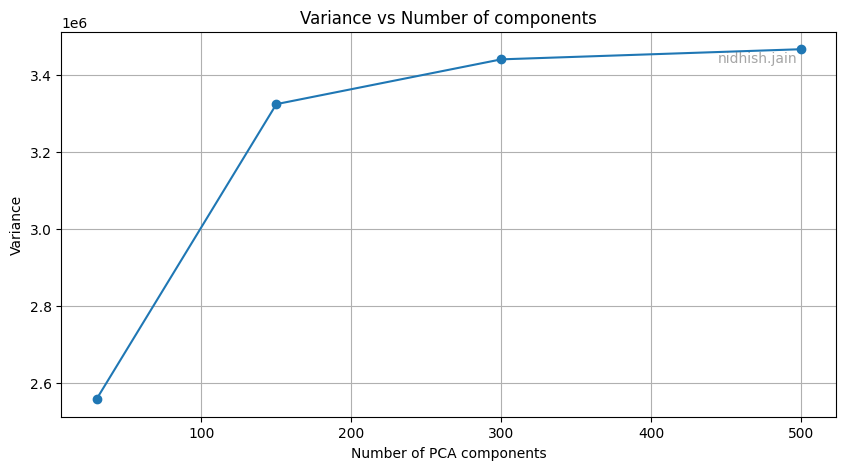

In [106]:
plt.figure(figsize=(10,5))
plt.plot(vals, variance, marker='o')
plt.xlabel("Number of PCA components")
plt.ylabel("Variance")
plt.title("Variance vs Number of components")
plt.grid()
add_watermark(plt.gca())
plt.show()


The variance is always increasing with the number of components however the rate of increase is decreasing. The variance is given by the ratio of sum of eigenvalues of selected components to the total sum of eigenvalues. As we select more components, the sum of selected eigenvalues approaches the total sum of eigenvalues, hence the variance approaches 1.

also if we plot the variance of curr/total variance vs number of components, we see that the curve is concave and increasing, approaching 1 asymptotically. this will match with the curve of taking the ratio of eigenvalues of curr component to total eigenvalues.

In [107]:
print(variance)

[3467697.396695119, 3441364.419129444, 3324978.224808064, 2557896.9075506628]


Variance values for components 500,300,150,30 respectively:
[0.99884348 0.99125847 0.95773433 0.73678247]
Ratio of sum of eigenvalues of selected components to total sum of eigenvalues:


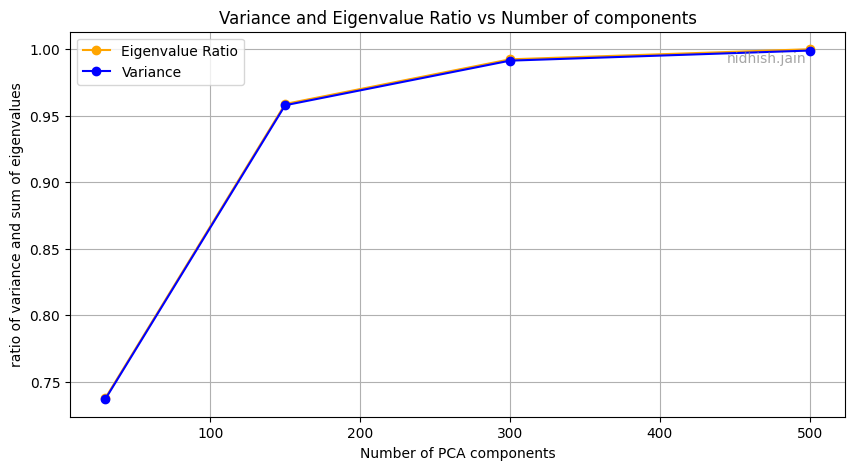

In [108]:
variance = variance / img_df.var().sum()
print("Variance values for components 500,300,150,30 respectively:")
print(variance)
pca_obj = PCA(30)
pca_obj.fit(img_df)
eigenvalues = pca_obj.eigenvalues
sum = eigenvalues.sum()
print("Ratio of sum of eigenvalues of selected components to total sum of eigenvalues:")
eigenvals_ratio = []
for val in vals:
    sum_till_now = np.sum(eigenvalues[:val])
    eigenvals_ratio.append(sum_till_now/sum)

plt.figure(figsize=(10,5))
plt.plot(vals, eigenvals_ratio, marker='o',color='orange')
plt.xlabel("Number of PCA components")
plt.ylabel("ratio of variance and sum of eigenvalues")
plt.plot(vals, variance, marker='o',color='blue')
plt.title("Variance and Eigenvalue Ratio vs Number of components")
plt.legend(["Eigenvalue Ratio","Variance"])
plt.grid()
add_watermark(plt.gca())
plt.show()

Clearly we can see both of these graphs overlap each other.

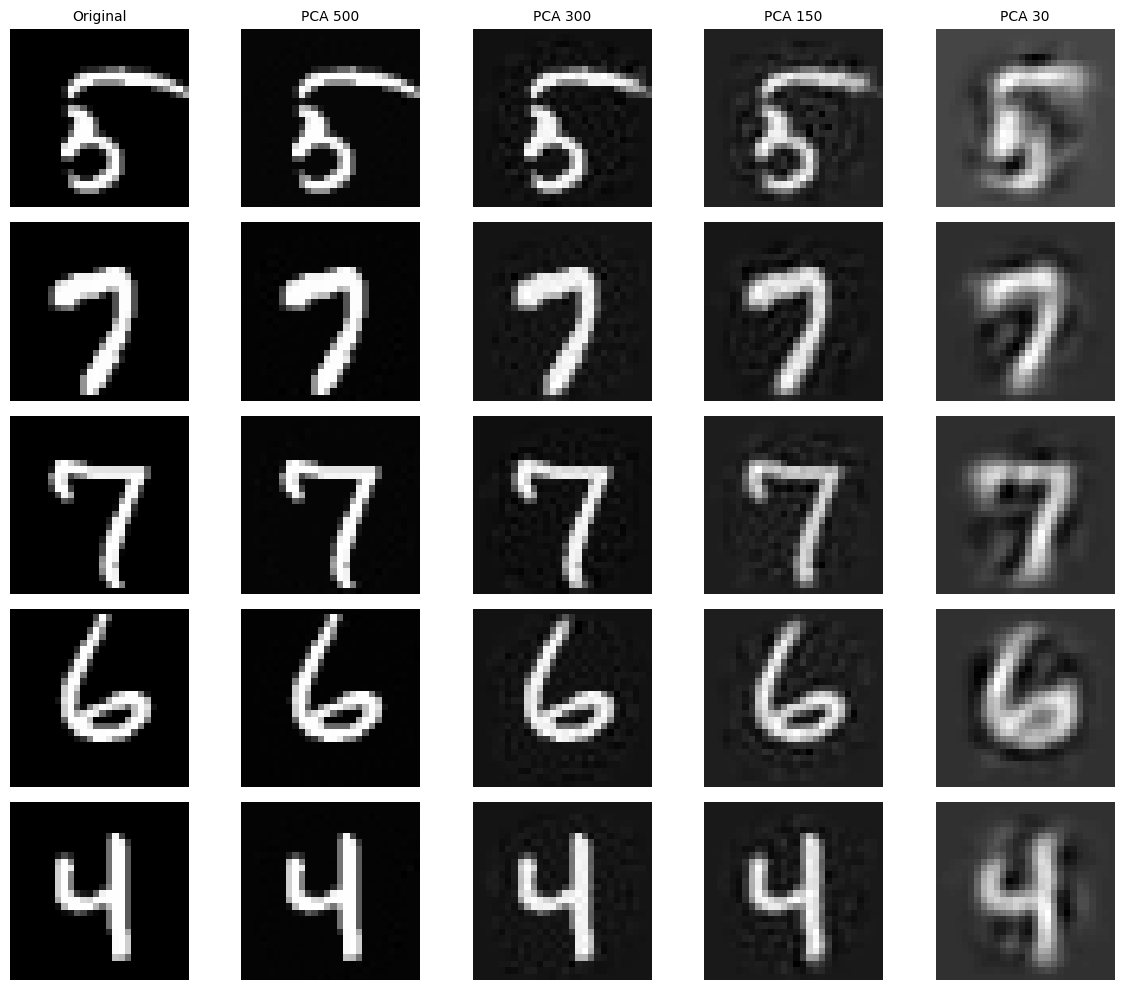

In [109]:
fig, axes = plt.subplots(5, 5, figsize=(12,10))
for i in range(5):
    for j in range(5):
        axes[i, j].imshow(imgs_final[i][j], cmap='gray')
        axes[i, j].axis('off')
        if i ==0 and j ==0 :
            axes[i, j].set_title("Original", fontsize=10)
        if i == 0 and j > 0:
            axes[i, j].set_title(f"PCA {vals[j-1]}", fontsize=10)
        if j == 0:
            axes[i, j].set_ylabel(f"Image {i+1}", fontsize=12)
plt.tight_layout()
plt.show()

The observation here is that as the number of components decreases, the reconstructed images lose detail and become more blurred. This is because fewer principal components are used to represent the original data, leading to a loss of information. But still in each we can see the significant details are preserved which shows the number however there is blurring and sharpness has been lost as we reduce the components number 